In [1]:
## Import necessary libraries

import mne
import numpy as np
import matplotlib.pyplot as plt
# import torch
from scipy.io import loadmat
from scipy.special import sph_harm
from numpy.linalg import solve

In [2]:
good = [2, 3, 4, 6, 7, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31, 33, 34, 36, 38, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 65]
good = np.array(good) - 1
subjects = ["01", "02", "04", "09", "15", "37", "79"]
auds = [f"{i:02d}" for i in range(1, 24)]

bad = set(range(65)) - set(good)
san_disk = 'D:/Universidad/2025_2/TDA/data'

In [3]:

# --- helpers ---
def cartesian_to_sph(x, y, z):
    # returns (theta, phi) where theta = colatitude [0, pi], phi = azimuth [0, 2pi)
    r = np.sqrt(x*x + y*y + z*z)
    theta = np.arccos(np.clip(z / (r + 1e-20), -1.0, 1.0))
    phi = np.mod(np.arctan2(y, x), 2*np.pi)
    return theta, phi

def real_sph_basis(Lmax, theta, phi):
    # theta,phi: arrays of length M
    # returns design matrix (M, ncoef) of real spherical harmonics bases
    M = theta.size
    coeffs = []
    for l in range(Lmax+1):
        for m in range(0, l+1):
            Y_lm = sph_harm(m, l, phi, theta)   # complex SH
            if m == 0:
                # m=0 is real
                coeffs.append(Y_lm.real)
            else:
                # for each m>0 we add sqrt(2)*Re and sqrt(2)*Im (real basis)
                coeffs.append(np.sqrt(2) * (-1)**m * Y_lm.real)  # cos part
                coeffs.append(np.sqrt(2) * (-1)**m * Y_lm.imag)  # sin part
    return np.column_stack(coeffs)  # shape (M, ncoef)

# --- example usage with electrode positions and values ---
# electrodes: array (N,3) cartesian coordinates on unit sphere
# values: array (N,) measured potentials

def sphharm_interpolate(electrode_xyz, values, Lmax, eval_theta, eval_phi, alpha=1e-6):
    theta_e, phi_e = cartesian_to_sph(electrode_xyz[:,0], electrode_xyz[:,1], electrode_xyz[:,2])
    G = real_sph_basis(Lmax, theta_e, phi_e)  # (N, ncoef)
    # regularized least squares: (G^T G + alpha I) a = G^T v
    GTG = G.T @ G
    ncoef = GTG.shape[0]
    a = solve(GTG + alpha * np.eye(ncoef), G.T @ values)
    # evaluate on target grid
    Gt = real_sph_basis(Lmax, eval_theta, eval_phi)  # (M, ncoef)
    values_grid = Gt @ a
    return values_grid.reshape(eval_theta.shape)

# --- creating a grid on the sphere and plotting (example) ---
def spherical_mesh(n_theta=64, n_phi=128):
    thetas = np.linspace(0, np.pi, n_theta)
    phis = np.linspace(0, 2*np.pi, n_phi, endpoint=False)
    th, ph = np.meshgrid(thetas, phis, indexing='xy')
    return th, ph

# --- Example run (replace electrode_xyz and values with your data) ---
# electrode_xyz: Nx3 unit vectors; values: Nx1
# electrode_xyz, values = your_data_here

# Example dummy electrodes (place your real coordinates here)
# electrode_xyz = np.array([[0,0,1], [0,1,0], [1,0,0], [-1,0,0], [0,-1,0], [0,0,-1]])
# values = np.array([1, 0.5, 0.2, -0.1, 0.0, -0.5])

# th, ph = spherical_mesh(80, 160)
# eval_theta = th.ravel()
# eval_phi = ph.ravel()
# grid_vals = sphharm_interpolate(electrode_xyz, values, Lmax=6, eval_theta=eval_theta, eval_phi=eval_phi, alpha=1e-4)
# grid_vals = grid_vals.reshape(th.shape)

# # simple plot on sphere using Mollweide (example)
# plt.figure(figsize=(8,4))
# plt.subplot(111)
# plt.pcolormesh(ph, np.cos(th), grid_vals, shading='auto')
# plt.title('Spherical-harmonic interpolation (projected)')
# plt.xlabel('phi'); plt.ylabel('cos(theta)')
# plt.colorbar()
# plt.show()

def plot_eeg_interpolation(elec_coords, elec_labels, interp_maps, th_grid, ph_grid, mask_rad = 1):
    # Normalize electrode coords (just in case)
    elec_xyz = elec_coords / np.linalg.norm(elec_coords, axis=1, keepdims=True)

    # Convert to spherical
    mask = th_grid <= np.pi * mask_rad  # keep points where theta <= 90°

    # Flatten arrays for plotting with tricontourf or scatter
    x = (th_grid / (np.pi/2)) * np.cos(ph_grid)  # normalize radius to upper hemisphere
    y = (th_grid / (np.pi/2)) * np.sin(ph_grid)

    x_masked = x[mask]
    y_masked = y[mask]

    # Project to 2D (same formula as before)

    theta_e, phi_e = cartesian_to_sph(elec_xyz[:,0], elec_xyz[:,1], elec_xyz[:,2])

    # Only plot electrodes in upper hemisphere
    mask_e = theta_e <= np.pi * mask_rad
    r_e = (theta_e / (np.pi/2))[mask_e]
    x_e = r_e * np.cos(phi_e[mask_e])
    y_e = r_e * np.sin(phi_e[mask_e])
    # r_e = theta_e / np.pi
    # x_e = r_e * np.cos(phi_e)
    # y_e = r_e * np.sin(phi_e)

    # Plot interpolation (one time frame t)
    plt.figure(figsize=(12,18))

    for i in range(21):
        t = 100*i
        point_data = interp_maps[t]
        data_masked = point_data[mask]



        plt.subplot(7,3,i+1)
        plt.tricontourf(x_masked, y_masked, data_masked, levels=50, cmap="RdBu_r")
        plt.scatter(x_e, y_e, c="k", s=30, marker="o")   # electrode markers
        for lbl, xe, ye in zip(elec_labels, x_e, y_e):   # optional labels
            plt.text(xe, ye, lbl[0], fontsize=8, ha="center", va="center", color="w")
        plt.gca().set_aspect("equal")
        plt.axis("off")
        plt.title(f"EEG azimuthal projection (t={t})")
        plt.colorbar(label="EEG potential")
        # plt.show()
    plt.tight_layout()
    plt.show()


In [4]:
## Load Channel data

labels = []
coords = {}

with open("GSN-HydroCel-65.sfp", "r") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 4:  # x y z label
            x, y, z = map(float, parts[1:4])
            label = parts[0]
            labels.append(label)
            coords[label] = (x, y, z)

bad_chans = [labels[3:][i] for i in bad]

# Load montage from .sfp file
montage = mne.channels.make_dig_montage()
montage = mne.channels.read_custom_montage("GSN-HydroCel-65.sfp")

info = mne.create_info(ch_names=labels[3:], sfreq=250, ch_types='eeg')
info.set_montage(montage)
info['bads'] = bad_chans

In [6]:
fname = 'data/sound_sep/slow/bb01_ut01.mat'
# 'data_name' is the name of the variable in the .mat file containing the FieldTrip structure
data = loadmat(fname)["subeeg"]

In [7]:
elec_labels = np.array([labels[3:][i] for i in good])
elec_coords = np.array([coords[label] for label in elec_labels])
eegdata = data[:,good]

In [8]:

elec_labels = np.array([labels[3:][i] for i in good])
elec_coords = np.array([coords[label] for label in elec_labels])
eegdata = data[:,good]

In [9]:

# 1. Normalize electrode coordinates onto unit sphere (important!)
elec_xyz = elec_coords / np.linalg.norm(elec_coords, axis=1, keepdims=True)

# 2. Choose spherical harmonics parameters
C = elec_xyz.shape[0]
Lmax = 5 # int(np.floor(np.sqrt(C)) - 1)   # safe upper bound
alpha = 1e-3                            # ridge regularization, tune if unstable

# 3. Build spherical-harmonic design matrix once for electrode positions
theta_e, phi_e = cartesian_to_sph(elec_xyz[:,0], elec_xyz[:,1], elec_xyz[:,2])
G = real_sph_basis(Lmax, theta_e, phi_e)   # shape (C, ncoef)
GTG = G.T @ G
ncoef = GTG.shape[0]
reg = alpha * np.eye(ncoef)
GT = G.T

# 4. Choose an evaluation grid on sphere (for interpolation maps)
th_grid, ph_grid = spherical_mesh(64, 128)
theta_eval = th_grid.ravel()
phi_eval   = ph_grid.ravel()
G_eval = real_sph_basis(Lmax, theta_eval, phi_eval)   # (M, ncoef)

# 5. Interpolate EEG at each timepoint



T, C = eegdata.shape
M = theta_eval.size
interp = np.zeros((T, M))

for t in range(T):
    values = eegdata[t, :]             # electrode potentials at time t
    a = np.linalg.solve(GTG + reg, GT @ values)  # SH coefficients
    interp[t, :] = G_eval @ a      # interpolated values on grid

# 6. Reshape to (T, n_theta, n_phi) if you want images per time
interp_maps = interp.reshape(T, th_grid.shape[0], th_grid.shape[1])

C:\Users\marti\AppData\Local\Temp\ipykernel_37360\3274328417.py:16: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  Y_lm = sph_harm(m, l, phi, theta)   # complex SH


In [10]:
def bandlimit_eeg_fft(eeg, Fs, bands):
    """
    Bandpass EEG by frequency bands using FFT.

    Parameters
    ----------
    eeg : ndarray, shape (n_samples, n_channels)
        EEG signal matrix
    Fs : float
        Sampling rate in Hz
    bands : list of tuples
        Frequency bands to keep, e.g. [(2,6),(6,9),(9,14),(14,20)]

    Returns
    -------
    eeg_bands : list of ndarray
        List of filtered EEG arrays, one per band, each shape (n_samples, n_channels)
    freqs : ndarray
        Frequency bins corresponding to the FFT
    """
    n_samples, n_channels = eeg.shape
    # FFT along time axis
    Xf = np.fft.rfft(eeg, axis=0)
    freqs = np.fft.rfftfreq(n_samples, 1/Fs)

    eeg_bands = []

    for (low, high) in bands:
        # Boolean mask for the frequency band
        mask = (freqs >= low) & (freqs <= high)
        # Apply mask (broadcast over channels)
        Xf_filt = Xf * mask[:, np.newaxis]
        # Reconstruct time-domain EEG
        eeg_filt = np.fft.irfft(Xf_filt, n=n_samples, axis=0)
        eeg_bands.append(eeg_filt)

    return eeg_bands, freqs

In [ ]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

subjects = ["01", "02", "04", "09", "15", "37", "79"]
auds = [f"{i:02d}" for i in range(1, 24)]
Fs = 250  # replace with your actual sampling rate
bands = [(2,6), (6,9), (9,14)]
bands_names = ['theta', 'alpha', 'beta']
# eeg = your EEG matrix of shape (2879, 65)


# Suppose your data has shape (T, n_phi, n_theta)
T, n_phi, n_theta = interp_maps.shape

# Angular grids (depends on your definition!)
phi = np.linspace(-np.pi, np.pi, n_phi)
theta = np.linspace(0, np.pi, n_theta)

# Target Cartesian grid
N = 50
x = np.linspace(-1, 1, N)
y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)

# Mask for the unit disk
mask = R <= 1

# Map to spherical angles (example: simple azimuthal projection)
phi_map = np.arctan2(Y, X)
theta_map = R * (np.pi / 2)

for m in range(1,7):#len(subjects)):
    for n in range(len(auds)):
        for speed in ["slow", "fast"]:
            fname = f'data/sound_sep/{speed}/bb{subjects[m]}_ut{auds[n]}.mat'
            try:
                data = loadmat(fname)["subeeg"]
            except FileNotFoundError:
                print(f"File {fname} not found, skipping.")
                continue
            eeg_data = data[:,good]
            eeg_data = eeg_data[::int(250/64),:]
            # eeg_data = eeg_data.astype(np.float32)
            eeg_data = (eeg_data - np.mean(eeg_data, axis=0)) / np.std(eeg_data, axis=0)
            eeg_bands, freqs = bandlimit_eeg_fft(eeg_data, 64, bands)
            for band_idx, band_data in enumerate(eeg_bands):
                eeg_data = band_data
                T, C = eeg_data.shape
                M = theta_eval.size
                interp = np.zeros((T, M))

                for t in range(T):
                    values = eeg_data[t, :]             # electrode potentials at time t
                    a = np.linalg.solve(GTG + reg, GT @ values)  # SH coefficients
                    interp[t, :] = G_eval @ a      # interpolated values on grid

                # # 6. Reshape to (T, n_theta, n_phi) if you want images per time
                interp_maps = interp.reshape(T, th_grid.shape[0], th_grid.shape[1])
                
                # proj = np.zeros((T, N, N))

                # # Loop over timepoints
                # for t in range(T):
                #     interpolator = RegularGridInterpolator((phi, theta), interp_maps[t], bounds_error=False, fill_value=0)
                #     pts = np.stack([phi_map[mask], theta_map[mask]], axis=-1)
                #     vals = interpolator(pts)
                #     frame = np.zeros((N, N))
                #     frame[mask] = vals
                #     proj[t] = frame

                # np.save(f"{san_disk}/eegs/harmonics/{speed}/{bands_names[band_idx]}/bb{subjects[m]}_ut{auds[n]}.npy", interp_maps)


File data/sound_sep/slow/bb02_ut01.mat not found, skipping.
File data/sound_sep/slow/bb02_ut16.mat not found, skipping.
File data/sound_sep/slow/bb04_ut04.mat not found, skipping.
File data/sound_sep/slow/bb09_ut03.mat not found, skipping.
File data/sound_sep/slow/bb09_ut10.mat not found, skipping.
File data/sound_sep/fast/bb09_ut10.mat not found, skipping.
File data/sound_sep/fast/bb09_ut11.mat not found, skipping.
File data/sound_sep/fast/bb15_ut08.mat not found, skipping.
File data/sound_sep/fast/bb79_ut13.mat not found, skipping.


In [13]:
print("hi")

hi


In [76]:
data1 = np.load("data_harmonics/bb01_ut01_slow_fr0_sphere.npy")
data2 = np.load("data_harmonics/bb01_ut02_slow_fr0_sphere.npy")

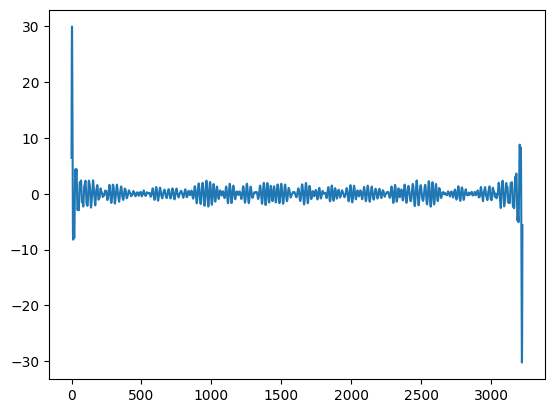

In [77]:
plt.plot(data1[:,20,25], label="2-6 Hz")

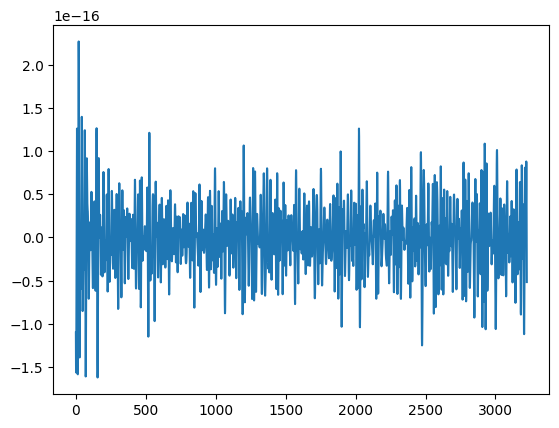

In [78]:
plt.plot(data2[:,20,25], label="6-9 Hz")

In [19]:
bands = [(2,6), (6,9), (9,14), (14,20)]

import numpy as np
from mne.time_frequency import tfr_array_morlet

# x: shape (n_epochs, n_channels, n_times)
# For a single epoch/channel:
# data = x[np.newaxis, np.newaxis, :]
freqs = np.linspace(2, 20, 100)  # fine frequency grid
n_cycles = freqs / 2.  # cycles per frequency

data = loadmat("data/sound_sep/slow/bb01_ut01.mat")["subeeg"]
data = data[:,good]
datta = np.reshape(data, (1, data.shape[1], data.shape[0]))


Fs = 250
power = tfr_array_morlet(datta, sfreq=Fs, freqs=freqs,
                         n_cycles=n_cycles, output='power')

# Average over desired bands:
def band_average(power, freqs, band):
    mask = (freqs >= band[0]) & (freqs <= band[1])
    return power[:, :, mask, :].mean(axis=2)

band_powers = [band_average(power, freqs, b) for b in bands]


In [33]:
datta.shape

(1, 65, 2879)

In [34]:
power.shape

(1, 65, 30, 2879)

In [20]:
power.shape

(1, 47, 100, 4606)

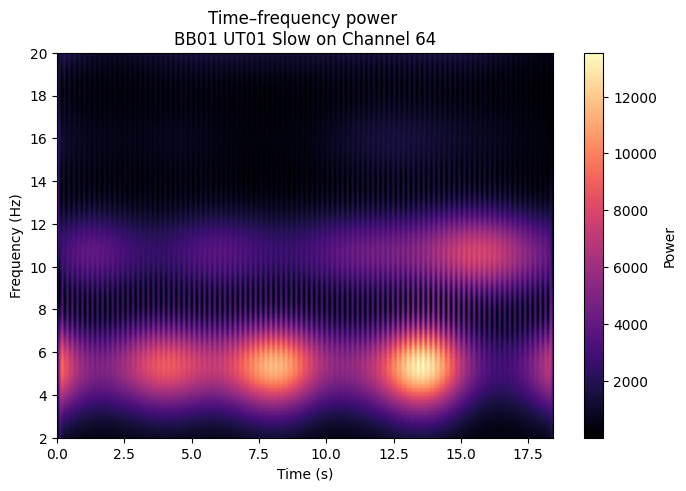

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Assume: power (1, 1, n_freqs, n_times)
#          freqs (n_freqs,)
#          Fs (sampling rate)

t = np.arange(power.shape[-1]) / Fs  # time vector in seconds
plt.figure(figsize=(8, 5))
plt.imshow(power[0, 46, :, :], aspect='auto', origin='lower',
           extent=[t[0], t[-1], freqs[0], freqs[-1]], cmap='magma')
plt.colorbar(label='Power')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title(f'Time–frequency power \nBB01 UT01 Slow on Channel {good[46]}')
plt.show()


## Banded

In [73]:
import numpy as np

def bandlimit_eeg_fft(eeg, Fs, bands):
    """
    Bandpass EEG by frequency bands using FFT.

    Parameters
    ----------
    eeg : ndarray, shape (n_samples, n_channels)
        EEG signal matrix
    Fs : float
        Sampling rate in Hz
    bands : list of tuples
        Frequency bands to keep, e.g. [(2,6),(6,9),(9,14),(14,20)]

    Returns
    -------
    eeg_bands : list of ndarray
        List of filtered EEG arrays, one per band, each shape (n_samples, n_channels)
    freqs : ndarray
        Frequency bins corresponding to the FFT
    """
    n_samples, n_channels = eeg.shape
    # FFT along time axis
    Xf = np.fft.rfft(eeg, axis=0)
    freqs = np.fft.rfftfreq(n_samples, 1/Fs)

    eeg_bands = []

    for (low, high) in bands:
        # Boolean mask for the frequency band
        mask = (freqs >= low) & (freqs <= high)
        # Apply mask (broadcast over channels)
        Xf_filt = Xf * mask[:, np.newaxis]
        # Reconstruct time-domain EEG
        eeg_filt = np.fft.irfft(Xf_filt, n=n_samples, axis=0)
        eeg_bands.append(eeg_filt)

    return eeg_bands, freqs

# Example usage ------------------------------------------------
Fs = 250  # replace with your actual sampling rate
bands = [(2,6), (6,9), (9,14), (14,20)]
# eeg = your EEG matrix of shape (2879, 65)

eeg_bands, freqs = bandlimit_eeg_fft(data, Fs, bands)

# eeg_bands[0] → 2-6 Hz, shape (2879,65)
# eeg_bands[1] → 6-9 Hz
# eeg_bands[2] → 9-14 Hz
# eeg_bands[3] → 14-20 Hz


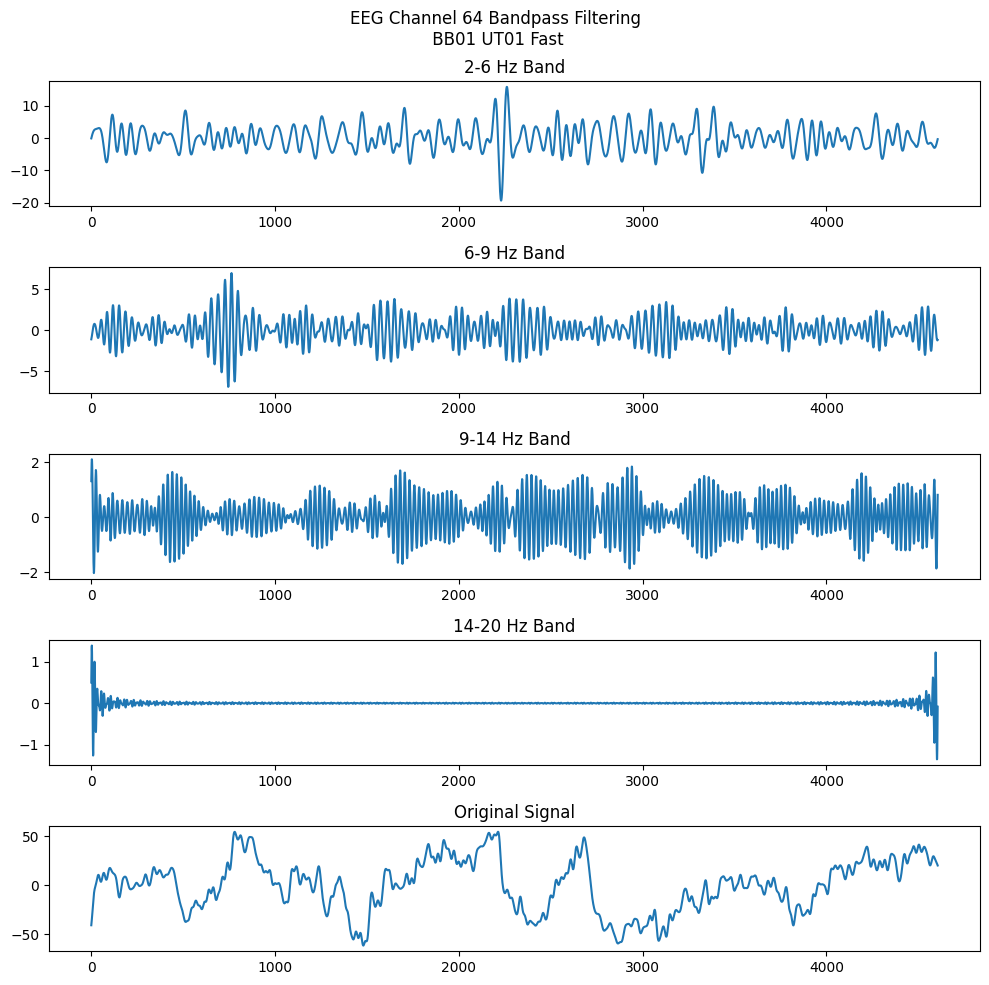

In [85]:
chan = 46
plt.figure(figsize=(10, 10))
plt.subplot(5,1,1)
plt.plot(eeg_bands[0][:,chan])
plt.title("2-6 Hz Band")
plt.subplot(5,1,2)
plt.plot(eeg_bands[1][:,chan])
plt.title("6-9 Hz Band")
plt.subplot(5,1,3)
plt.plot(eeg_bands[2][:,chan])
plt.title("9-14 Hz Band")
plt.subplot(5,1,4)
plt.plot(eeg_bands[3][:,chan])
plt.title("14-20 Hz Band")
plt.subplot(5,1,5)
plt.plot(data[:,0])
plt.title("Original Signal")
plt.suptitle(f"EEG Channel {good[chan]} Bandpass Filtering\n BB01 UT01 Fast")
plt.tight_layout()
plt.show()


In [81]:
eeg_bands[0].shape

(3225, 47)

In [91]:
data_eeg = np.load("data_harmonics/bb04_ut03_slow_fr0_sphere.npy")

In [159]:
data_eeg.shape

(3225, 128, 64)

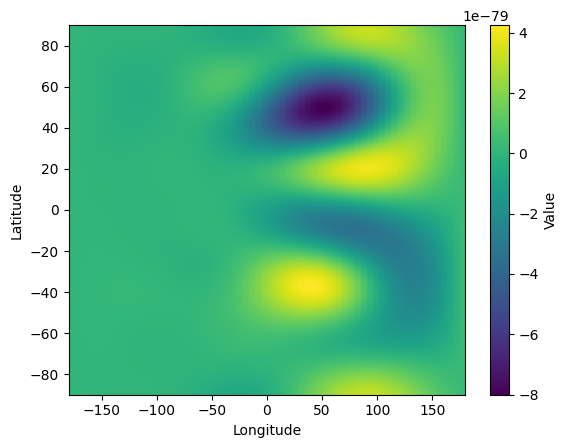

In [109]:
import numpy as np

# data = np.random.randn(1, 8192)  # your array
data_2d = data_eeg[0]

lats = np.linspace(-90, 90, 64)         # latitude
lons = np.linspace(-180, 180, 128)      # longitude
lon_grid, lat_grid = np.meshgrid(lons, lats)



plt.imshow(data_2d, extent=[-180, 180, -90, 90], origin='lower', aspect='auto', cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Value')
plt.show()


IndexError: index 4 is out of bounds for axis 0 with size 4

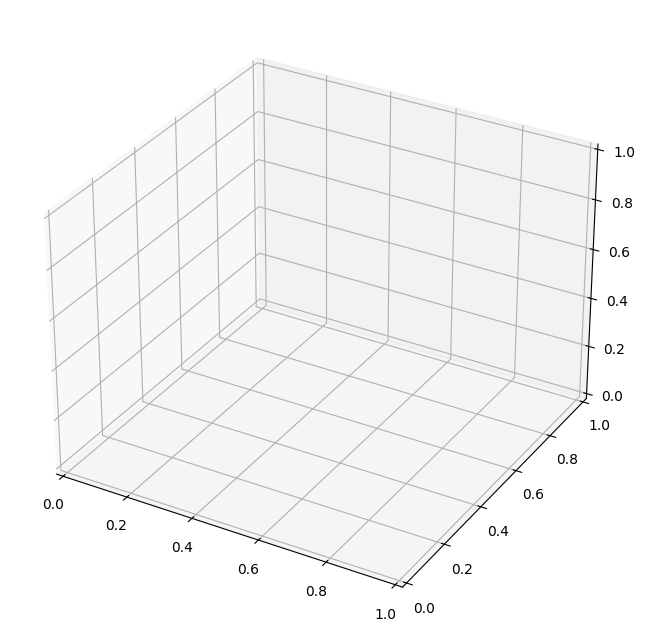

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ==== Your data ====
# data = np.random.randn(8192)  # replace this with your actual array
data_2d = data_eeg[120]

# ==== Create spherical coordinates ====
lats = np.linspace(-90, 90, 128)
lons = np.linspace(-180, 180, 64)
lat_r = np.radians(lats)
lon_r = np.radians(lons)

# Meshgrid for surface
lon_grid, lat_grid = np.meshgrid(lon_r, lat_r)
r = 1  # radius

# Convert spherical to cartesian
X = r * np.cos(lat_grid) * np.cos(lon_grid)
Y = r * np.cos(lat_grid) * np.sin(lon_grid)
Z = r * np.sin(lat_grid)

# Normalize data for color mapping
norm_data = (data_2d - np.min(data_2d)) / (np.max(data_2d) - np.min(data_2d))

# ==== Plot ====
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    X, Y, Z,
    facecolors=plt.cm.viridis(norm_data),
    rstride=1, cstride=1,
    antialiased=False,
    shade=False
)

ax.set_box_aspect([1, 1, 1])
ax.axis('off')
plt.tight_layout()
plt.show()


In [99]:
data_sq = np.load("data_harmonics/bb01_ut04_slow_fr1_sphere.npy")

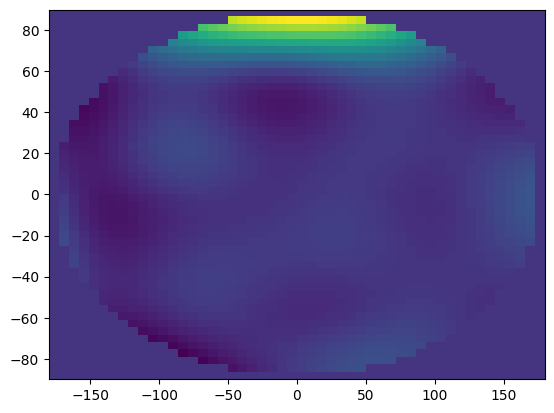

In [105]:
plt.imshow(data_sq[1800], extent=[-180, 180, -90, 90], origin='lower', aspect='auto', cmap='viridis')

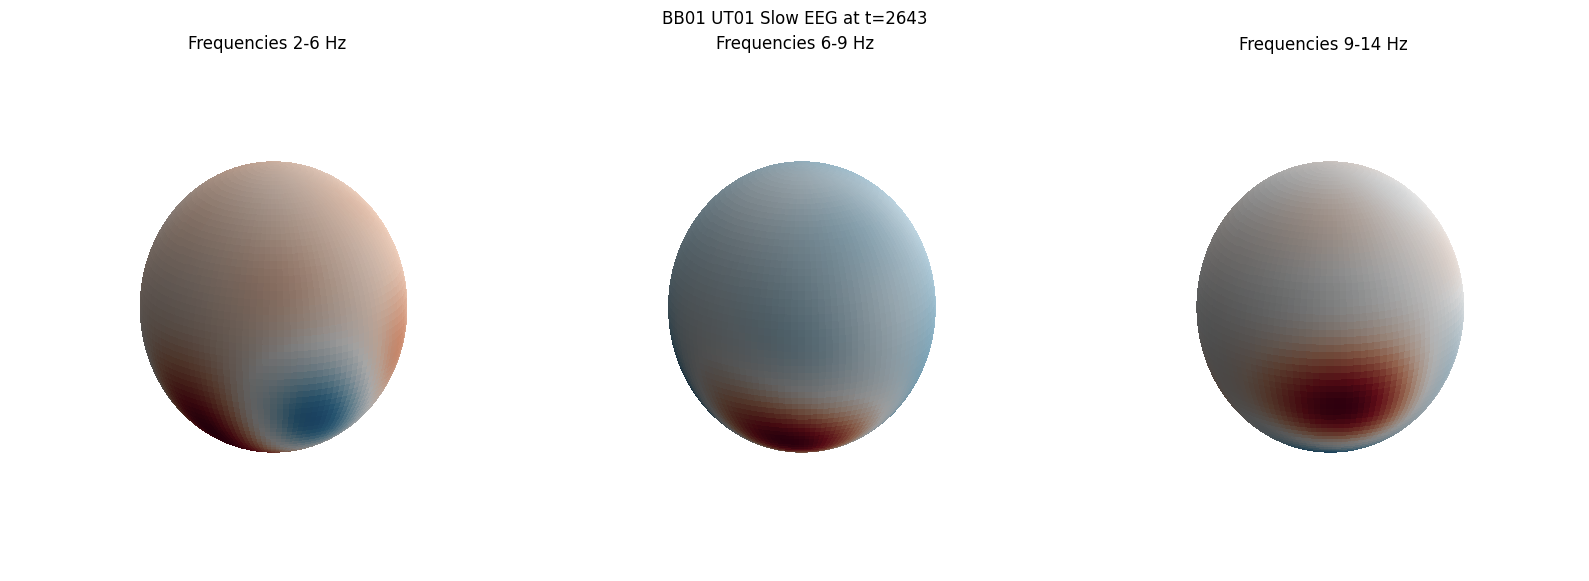

In [105]:
from mpl_toolkits.mplot3d import Axes3D
data_eeg = np.load("data_harmonics/bb01_ut01_slow_fr0_sphere.npy")
t = 2643
point_data = data_eeg[t]

# Convert spherical grid to cartesian
x = np.sin(th_grid) * np.cos(ph_grid)
y = np.sin(th_grid) * np.sin(ph_grid)
z = np.cos(th_grid)

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(131, projection="3d")
ax.set_title("Frequencies 2-6 Hz")

# Plot surface
surf = ax.plot_surface(x, y, z, facecolors=plt.cm.RdBu_r((point_data-point_data.min())/(point_data.max()-point_data.min())),
                       rstride=1, cstride=1, antialiased=False, linewidth=0)

ax.set_box_aspect([1,1,1])
ax.set_axis_off()
ax.view_init(elev=20, azim=100)

data_eeg = np.load("data_harmonics/bb01_ut01_slow_fr1_sphere.npy")
# t = 1200
point_data = data_eeg[t]

# Convert spherical grid to cartesian
x = np.sin(th_grid) * np.cos(ph_grid)
y = np.sin(th_grid) * np.sin(ph_grid)
z = np.cos(th_grid)

ax = fig.add_subplot(132, projection="3d")
ax.set_title("Frequencies 6-9 Hz")

# Plot surface
surf = ax.plot_surface(x, y, z, facecolors=plt.cm.RdBu_r((point_data-point_data.min())/(point_data.max()-point_data.min())),
                       rstride=1, cstride=1, antialiased=False, linewidth=0)

ax.set_box_aspect([1,1,1])
ax.set_axis_off()
ax.view_init(elev=20, azim=100)

data_eeg = np.load("data_harmonics/bb01_ut01_slow_fr2_sphere.npy")
# t = 1200
point_data = data_eeg[t]

# Convert spherical grid to cartesian
x = np.sin(th_grid) * np.cos(ph_grid)
y = np.sin(th_grid) * np.sin(ph_grid)
z = np.cos(th_grid)

ax = fig.add_subplot(133, projection="3d")
ax.set_title("Frequencies 9-14 Hz")

# Plot surface
surf = ax.plot_surface(x, y, z, facecolors=plt.cm.RdBu_r((point_data-point_data.min())/(point_data.max()-point_data.min())),
                       rstride=1, cstride=1, antialiased=False, linewidth=0)

ax.set_box_aspect([1,1,1])
ax.set_axis_off()
ax.view_init(elev=20, azim=100)
fig.suptitle("BB01 UT01 Slow EEG at t=2643")
fig.tight_layout()
plt.show()

In [163]:
data_eeg = np.load("data_harmonics/bb01_ut01_fast_fr1_sphere.npy")

In [170]:
import numpy as np
import gudhi as gd

T = data_eeg.shape[0]
window_size = 64   # e.g. 50 time steps
step = 1          # move the window 10 steps each time


In [171]:
def aggregate_window(data, start, window_size):
    # average over the window along time
    return np.mean(data[start:start+window_size], axis=0)


In [172]:
persistence_diagrams = []
time_centers = []

for start in range(0, T - window_size + 1, step):
    f = aggregate_window(data_eeg, start, window_size)
    
    cc = gd.CubicalComplex(dimensions=f.shape, top_dimensional_cells=f.ravel())
    diag = cc.persistence()
    
    persistence_diagrams.append(diag)
    time_centers.append(start + window_size // 2)


In [173]:
def betti_numbers(diagram):
    betti = {0:0, 1:0, 2:0}
    for dim, (birth, death) in diagram:
        if np.isfinite(death):  # ignore infinite deaths
            betti[dim] += 1
    return betti

betti_series = []
for diag in persistence_diagrams:
    betti_series.append(betti_numbers(diag))

betti0 = [b[0] for b in betti_series]
betti1 = [b[1] for b in betti_series]

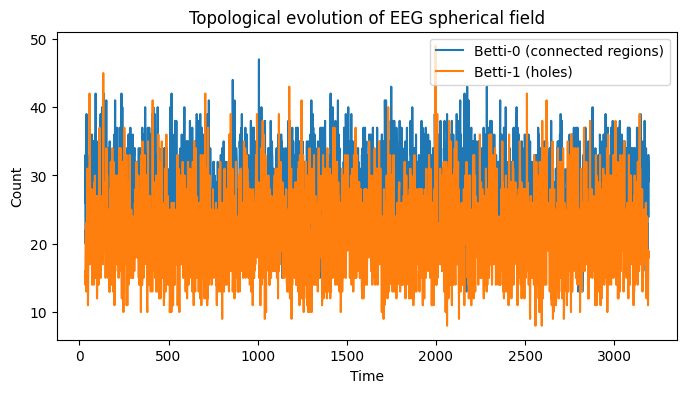

In [174]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(time_centers, betti0, label='Betti-0 (connected regions)')
plt.plot(time_centers, betti1, label='Betti-1 (holes)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.title('Topological evolution of EEG spherical field')
plt.show()


In [176]:
import gudhi as gd
import numpy as np

T, Nphi, Ntheta = data_eeg.shape
betti_series = []

for t in range(T):
    f = data_eeg[t]  # shape (128, 64)
    cc = gd.CubicalComplex(dimensions=f.shape, top_dimensional_cells=f.ravel())
    diag = cc.persistence()

    # Extract Betti numbers (connected components, loops, voids)
    betti = {0: 0, 1: 0, 2: 0}
    for dim, (birth, death) in diag:
        if np.isfinite(death):
            betti[dim] += 1
    betti_series.append([betti[0], betti[1], betti[2]])

betti_series = np.array(betti_series)  # shape (T, 3)


In [194]:
from gtda.time_series import TakensEmbedding

betti1 = betti_series[:, 1]  # e.g. number of "holes" in the field
embedding_dim = 2      # number of delay coordinates
delay = 250              # time lag between coordinates

takens = TakensEmbedding(time_delay=delay, dimension=embedding_dim)
embedded = takens.fit_transform(betti1.reshape(1, 1, len(betti1)))
print(embedded.shape)  # -> (T - (dimension - 1)*delay, dimension)


(1, 2975, 2)


In [196]:
def takens_numpy(x, m=3, tau=10):
    """Takens embedding simple para una serie 1D -> matriz (N-(m-1)tau, m)."""
    N = len(x) - (m-1)*tau
    if N <= 0:
        raise ValueError("Serie muy corta para estos parámetros (m, tau).")
    return np.vstack([x[i:i+N] for i in range(0, m*tau, tau)]).T

In [198]:
tau = 1
emb2 = takens_numpy(betti1, m=2, tau=tau)
emb3 = takens_numpy(betti1, m=3, tau=tau)

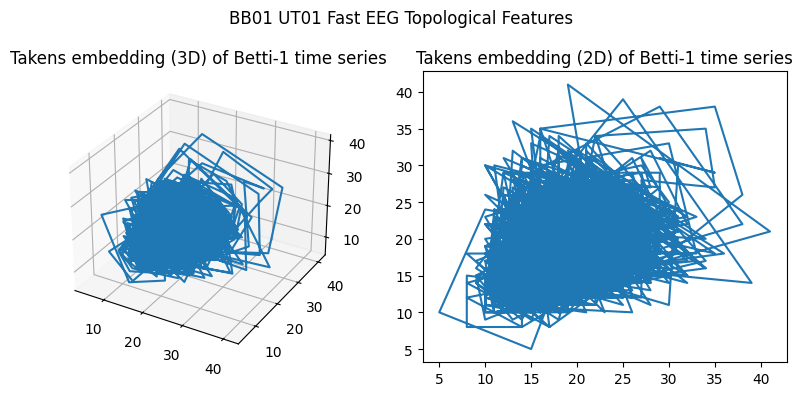

In [208]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(121, projection='3d')
ax.plot(emb3[:,0], emb3[:,1], emb3[:,2])
ax.set_title("Takens embedding (3D) of Betti-1 time series")
ax2 = fig.add_subplot(122)
ax2.plot(emb2[:,0], emb2[:,1])
ax2.set_title("Takens embedding (2D) of Betti-1 time series")
fig.suptitle("BB01 UT01 Fast EEG Topological Features")
fig.tight_layout()
plt.show()


In [ ]:
from gudhi import RipsComplex

rips = RipsComplex(points=embedded, max_edge_length=2.0)
st = rips.create_simplex_tree(max_dimension=2)
diag = st.persistence()
gd.plot_persistence_diagram(diag)


In [183]:
betti1.reshape(-1, 1).shape

(3225, 1)